# Complex Mosaicing


Optimizes the image coverage search to avoid scene overlaps. Only downloads the neccessary parts.

Download the overlap area, and each unique area. Each in one job. For the overlap area the scene with the lowest cloudcover.

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import copy

import geopandas as gpd
%matplotlib inline
import matplotlib.pyplot as plt
import rasterio
from rasterio.merge import merge
import pandas as pd

import up42

In [2]:
# Catalog currently only works with account authentification!
api = up42.Api(auth_type="account", cfg_file="config.json", env="dev")

2020-03-19 13:37:06,457 - up42.api - INFO - Got credentials from config.json.
2020-03-19 13:37:06,458 - up42.api - INFO - Using authentification type - account


In [3]:
outdir = Path.cwd() / "complex_pleiades_fullscene"
outdir.mkdir(parents=True, exist_ok=True)

## Define aoi

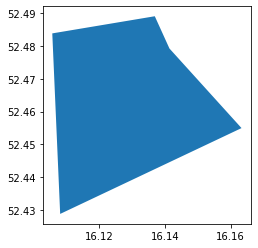

In [4]:
aoi = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              16.136856079101562,
              52.48905227994953
            ],
            [
              16.105613708496094,
              52.48382562716317
            ],
            [
              16.108016967773438,
              52.42880360005013
            ],
            [
              16.163291931152337,
              52.45496332664627
            ],
            [
              16.14131927490234,
              52.47922565896135
            ],
            [
              16.136856079101562,
              52.48905227994953
            ]
          ]
        ]
      }
    }
  ]
}
        

aoi = gpd.GeoDataFrame.from_features(
    aoi, crs={"init": "epsg:4326"}
)
aoi.plot()

## Search available images

,geometry,id,acquisitionDate,constellation,providerName,blockNames,cloudCoverage,providerProperties,scene_id
0,"POLYGON ((15.83374 52.63821, 16.14682 52.63398...",f2242438-10cf-4a2a-8be3-542732b383f3,2018-08-08T10:20:14Z,PHR,oneatlas,"[oneatlas-pleiades-fullscene, oneatlas-pleiade...",0.0,"{'commercialReference': 'SO18031593', 'acquisi...",DS_PHR1B_201808081020148_FR1_PX_E015N52_1214_0...
1,"POLYGON ((15.84263 52.47198, 16.13821 52.47199...",ac1f249c-39e5-4d33-8f95-565cc3ef0025,2018-08-03T10:09:00Z,PHR,oneatlas,"[oneatlas-pleiades-fullscene, oneatlas-pleiade...",0.0,"{'commercialReference': 'SO18031831', 'acquisi...",DS_PHR1B_201808031009003_FR1_PX_E015N52_1210_0...


<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   geometry            2 non-null      geometry
 1   id                  2 non-null      object  
 2   acquisitionDate     2 non-null      object  
 3   constellation       2 non-null      object  
 4   providerName        2 non-null      object  
 5   blockNames          2 non-null      object  
 6   cloudCoverage       2 non-null      float64 
 7   providerProperties  2 non-null      object  
 8   scene_id            2 non-null      object  
dtypes: float64(1), geometry(1), object(7)
memory usage: 160.0+ bytes


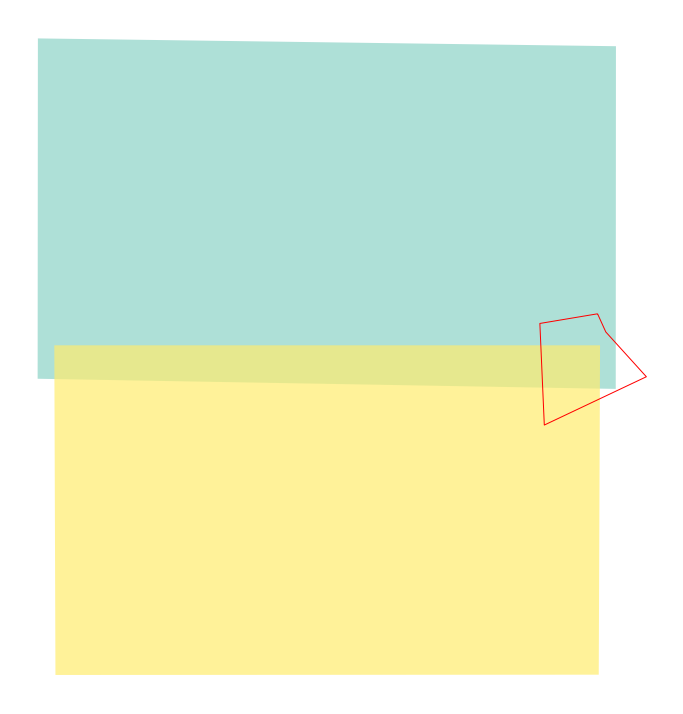

In [5]:
catalog = up42.Catalog(api=api)
search_paramaters = catalog.construct_parameter(geometry=aoi, 
                                                start_date="2018-08-02",
                                                end_date="2020-08-09",
                                                sensors=["pleiades"],
                                                max_cloudcover=20,
                                                sortby="cloudCoverage", 
                                                limit=2)
#print(search_paramaters)

search_results = catalog.search(search_paramaters=search_paramaters, as_dataframe=True)
display(search_results.head())
search_results.info()

catalog.plot_coverage(scenes=search_results, aoi=aoi)

## Full scene quicklooks

/Users/christoph.rieke/.virtualenvs/up42-py/lib/python3.7/site-packages/rasterio/__init__.py:219: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


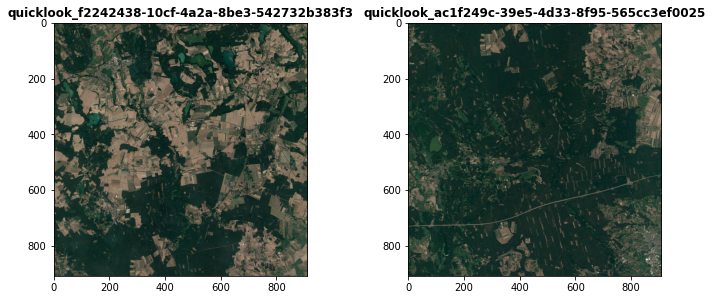

In [6]:
catalog.download_quicklook(image_ids=search_results["id"].tolist(), provider="oneatlas", out_dir=outdir / "quicklooks")
catalog.plot_quicklook(figsize=(10,10))

## Get non-overlapping sections

In [7]:
df = search_results[["geometry", "id", "scene_id", "cloudCoverage"]]
display(df)

df.to_file(driver="GeoJSON", filename=outdir / "search_results.geojson")

,geometry,id,scene_id,cloudCoverage
0,"POLYGON ((15.83374 52.63821, 16.14682 52.63398...",f2242438-10cf-4a2a-8be3-542732b383f3,DS_PHR1B_201808081020148_FR1_PX_E015N52_1214_0...,0.0
1,"POLYGON ((15.84263 52.47198, 16.13821 52.47199...",ac1f249c-39e5-4d33-8f95-565cc3ef0025,DS_PHR1B_201808031009003_FR1_PX_E015N52_1210_0...,0.0


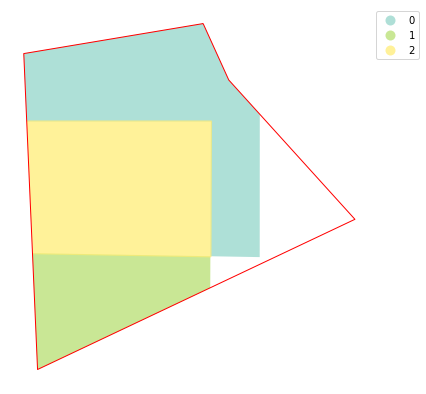

In [8]:
# Clip to aoi
clipped = gpd.clip(df, aoi.iloc[0].geometry)

# Get overlap area of unique scenes
import itertools
geoms = clipped['geometry'].tolist()
overlap = gpd.GeoDataFrame(gpd.GeoSeries([poly[0].intersection(poly[1]) for poly in  itertools.combinations(geoms, 2) 
                                          if poly[0].intersects(poly[1])]), columns=['geometry'])

# Get remaining unique areas
unique_areas = gpd.overlay(clipped, overlap, how='difference')

# Buffer overlap area sligthly
buffersize = 0.0002      # TODO: Buffer in meter
overlap.geometry = overlap.geometry.buffer(buffersize)
overlap = gpd.clip(overlap, aoi.iloc[0].geometry)

# Combine overlap (with the scene of lowest cc) and remaining areas in one df
overlap_lowest_cc = df.iloc[[0]].copy()
overlap_lowest_cc.geometry = overlap.geometry

sections = gpd.GeoDataFrame( pd.concat( [unique_areas, overlap_lowest_cc], ignore_index=True) )
sections["uid"] = list(range(sections.shape[0]))
sections.to_file(driver="GeoJSON", filename=outdir / "sections.geojson")

api.plot_coverage(sections, aoi=aoi, legend_column="uid", figsize=(7,7))

## Download sections

In [9]:
#selected_block = "oneatlas-pleiades-fullscene"
selected_block = "oneatlas-pleiades-aoiclipped"

In [10]:
project = api.create_project("mosaicing", use_existing=True)
workflow = project.create_workflow("mosaicing", use_existing=True)

blocks=api.get_blocks(basic=True)
workflow.add_workflow_tasks([blocks[selected_block]])

2020-03-19 13:37:29,707 - up42.api - INFO - Using existing project: mosaicing, 5558ea8e-5f89-4a71-a5b3-82ff0b05de84.
2020-03-19 13:37:30,886 - up42.project - INFO - Using existing workflow: mosaicing, c5e06156-17a0-4a7c-9351-75445d8d7cc6.
2020-03-19 13:37:31,652 - up42.api - INFO - Getting public blocks.
2020-03-19 13:37:32,514 - up42.api - INFO - Getting public blocks.
2020-03-19 13:37:33,186 - up42.workflow - INFO - Added tasks to workflow: [{'name': 'oneatlas-pleiades-aoiclipped:1', 'parentName': None, 'blockId': 'f026874d-e95e-4293-b811-7667130e054d'}]


In [11]:
# Download sections

jobs = {}
for idx, row in sections.iterrows():

    parameters = workflow.construct_parameter(geometry=row.geometry, 
                                              geometry_operation="intersects", 
                                              scene_ids=[row["scene_id"]])
    print(parameters)

    job = workflow.create_and_run_job(parameters)
    job.track_status(report_time=120)
    
    out_filepaths = job.download_result(out_dir=outdir / "sections")
    jobs[out_filepaths[0]] = job
    
print("finished")

2020-03-19 13:37:37,947 - up42.workflow - INFO - Selected input_parameters: {'oneatlas-pleiades-aoiclipped:1': {'limit': 1, 'zoom_level': 18, 'max_cloud_cover': 100, 'panchromatic_band': False, 'ids': ['DS_PHR1B_201808081020148_FR1_PX_E015N52_1214_01804'], 'intersects': {'type': 'Polygon', 'coordinates': (((16.107131606131713, 52.44907373599218), (16.105613708496094, 52.48382562716317), (16.136856079101562, 52.48905227994953), (16.14131927490234, 52.47922565896135), (16.146722901526523, 52.473258943632494), (16.1467082, 52.4483786), (16.107131606131713, 52.44907373599218)), ((16.107131606131713, 52.44907373599218), (16.13811425238671, 52.4485295468531), (16.13820711, 52.47198654), (16.106130835180203, 52.47198613955475), (16.107131606131713, 52.44907373599218)))}}}.


{'oneatlas-pleiades-aoiclipped:1': {'limit': 1, 'zoom_level': 18, 'max_cloud_cover': 100, 'panchromatic_band': False, 'ids': ['DS_PHR1B_201808081020148_FR1_PX_E015N52_1214_01804'], 'intersects': {'type': 'Polygon', 'coordinates': (((16.107131606131713, 52.44907373599218), (16.105613708496094, 52.48382562716317), (16.136856079101562, 52.48905227994953), (16.14131927490234, 52.47922565896135), (16.146722901526523, 52.473258943632494), (16.1467082, 52.4483786), (16.107131606131713, 52.44907373599218)), ((16.107131606131713, 52.44907373599218), (16.13811425238671, 52.4485295468531), (16.13820711, 52.47198654), (16.106130835180203, 52.47198613955475), (16.107131606131713, 52.44907373599218)))}}}


2020-03-19 13:37:39,582 - up42.workflow - INFO - Created and running new job: ce6b9dea-a63a-4275-aa31-47672a05342d.
2020-03-19 13:37:40,155 - up42.job - INFO - Tracking job status every 120 seconds
2020-03-19 13:37:40,720 - up42.job - INFO - Job is PENDING! - ce6b9dea-a63a-4275-aa31-47672a05342d
2020-03-19 13:39:55,036 - up42.job - INFO - Job is RUNNING! - ce6b9dea-a63a-4275-aa31-47672a05342d
2020-03-19 13:40:22,662 - up42.job - INFO - Job finished successfully ce6b9dea-a63a-4275-aa31-47672a05342d - SUCCEEDED!
2020-03-19 13:40:23,534 - up42.job - INFO - Downloading results of job ce6b9dea-a63a-4275-aa31-47672a05342d
2020-03-19 13:41:31,265 - up42.job - INFO - Download successful of 1 files ['/Users/christoph.rieke/repos/mosaicing/complex_pleiades_fullscene/sections/ce6b9dea-a63a-4275-aa31-47672a05342d_0.tif']
2020-03-19 13:41:32,306 - up42.workflow - INFO - Selected input_parameters: {'oneatlas-pleiades-aoiclipped:1': {'limit': 1, 'zoom_level': 18, 'max_cloud_cover': 100, 'panchromatic

{'oneatlas-pleiades-aoiclipped:1': {'limit': 1, 'zoom_level': 18, 'max_cloud_cover': 100, 'panchromatic_band': False, 'ids': ['DS_PHR1B_201808031009003_FR1_PX_E015N52_1210_01804'], 'intersects': {'type': 'Polygon', 'coordinates': (((16.13811425238671, 52.4485295468531), (16.138092510652992, 52.44303731330592), (16.108016967773438, 52.42880360005013), (16.107131606131713, 52.44907373599218), (16.13811425238671, 52.4485295468531)),)}}}


2020-03-19 13:41:33,563 - up42.workflow - INFO - Created and running new job: 83811796-8783-4982-a64a-1e1f4307ea02.
2020-03-19 13:41:34,142 - up42.job - INFO - Tracking job status every 120 seconds
2020-03-19 13:41:34,658 - up42.job - INFO - Job is PENDING! - 83811796-8783-4982-a64a-1e1f4307ea02
2020-03-19 13:42:58,748 - up42.job - INFO - Job finished successfully 83811796-8783-4982-a64a-1e1f4307ea02 - SUCCEEDED!
2020-03-19 13:42:59,688 - up42.job - INFO - Downloading results of job 83811796-8783-4982-a64a-1e1f4307ea02
2020-03-19 13:43:34,259 - up42.job - INFO - Download successful of 1 files ['/Users/christoph.rieke/repos/mosaicing/complex_pleiades_fullscene/sections/83811796-8783-4982-a64a-1e1f4307ea02_0.tif']
2020-03-19 13:43:35,018 - up42.workflow - INFO - Selected input_parameters: {'oneatlas-pleiades-aoiclipped:1': {'limit': 1, 'zoom_level': 18, 'max_cloud_cover': 100, 'panchromatic_band': False, 'ids': ['DS_PHR1B_201808081020148_FR1_PX_E015N52_1214_01804'], 'intersects': {'type'

{'oneatlas-pleiades-aoiclipped:1': {'limit': 1, 'zoom_level': 18, 'max_cloud_cover': 100, 'panchromatic_band': False, 'ids': ['DS_PHR1B_201808081020148_FR1_PX_E015N52_1214_01804'], 'intersects': {'type': 'Polygon', 'coordinates': (((16.13831425081965, 52.44852875513283), (16.138313192760982, 52.44850898651545), (16.13831018549586, 52.448489419347084), (16.138305258489297, 52.44847024534574), (16.13829846001582, 52.44845165237719), (16.138289856686487, 52.44843382261427), (16.138279532796233, 52.448416930751996), (16.13826758949794, 52.448401142295864), (16.138254143811366, 52.448386611940265), (16.138239327476583, 52.4483734820528), (16.138223285663194, 52.44836188127936), (16.138206175547975, 52.44835192328365), (16.13818816477486, 52.44834370563357), (16.138169429812375, 52.44833730884516), (16.138150154224615, 52.44833279559381), (16.138130526872697, 52.44833021010008), (16.13811074006429, 52.448329577696505), (16.10714034981314, 52.448873551567196), (16.106122118777225, 52.47218569

2020-03-19 13:43:36,347 - up42.workflow - INFO - Created and running new job: e3b93ac6-8dc9-4089-81d0-5645588bd408.
2020-03-19 13:43:36,917 - up42.job - INFO - Tracking job status every 120 seconds
2020-03-19 13:43:37,534 - up42.job - INFO - Job is PENDING! - e3b93ac6-8dc9-4089-81d0-5645588bd408
2020-03-19 13:45:45,927 - up42.job - INFO - Job finished successfully e3b93ac6-8dc9-4089-81d0-5645588bd408 - SUCCEEDED!
2020-03-19 13:45:46,653 - up42.job - INFO - Downloading results of job e3b93ac6-8dc9-4089-81d0-5645588bd408
2020-03-19 13:46:49,416 - up42.job - INFO - Download successful of 1 files ['/Users/christoph.rieke/repos/mosaicing/complex_pleiades_fullscene/sections/e3b93ac6-8dc9-4089-81d0-5645588bd408_0.tif']


finished


['/Users/christoph.rieke/repos/mosaicing/complex_pleiades_fullscene/sections/ce6b9dea-a63a-4275-aa31-47672a05342d_0.tif', '/Users/christoph.rieke/repos/mosaicing/complex_pleiades_fullscene/sections/83811796-8783-4982-a64a-1e1f4307ea02_0.tif', '/Users/christoph.rieke/repos/mosaicing/complex_pleiades_fullscene/sections/e3b93ac6-8dc9-4089-81d0-5645588bd408_0.tif']


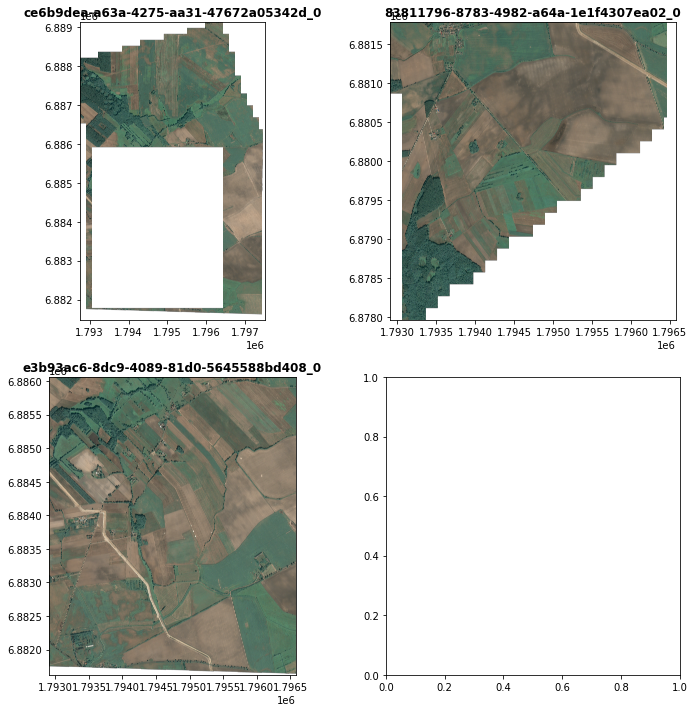

In [12]:
job_results=list(jobs.keys())
print(job_results)

api.plot_result(figsize=(10,10), filepaths=job_results)

## Mosaic sections

In [13]:
src_files_to_mosaic = []
for fp in job_results:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)

    out_profile = src.profile.copy() # bzw. src.meta
print(src_files_to_mosaic)


mosaic, out_transform = merge(src_files_to_mosaic)
print(mosaic.shape)



out_profile.update({
    'height': mosaic.shape[1],
    'width': mosaic.shape[2],
    'transform': out_transform,
    'blockxsize':256,
    'blockysize':256,
    'tiled' : True  # Important for definition block structure!  
})

out_path = outdir / "mosaic_pleiades_complex.tif"
# Write raster.
with rasterio.open(out_path, 'w', **out_profile) as dst:
        for i in range(mosaic.shape[0]):
            dst.write(mosaic[i,...], i+1)

[<open DatasetReader name='/Users/christoph.rieke/repos/mosaicing/complex_pleiades_fullscene/sections/ce6b9dea-a63a-4275-aa31-47672a05342d_0.tif' mode='r'>, <open DatasetReader name='/Users/christoph.rieke/repos/mosaicing/complex_pleiades_fullscene/sections/83811796-8783-4982-a64a-1e1f4307ea02_0.tif' mode='r'>, <open DatasetReader name='/Users/christoph.rieke/repos/mosaicing/complex_pleiades_fullscene/sections/e3b93ac6-8dc9-4089-81d0-5645588bd408_0.tif' mode='r'>]
(4, 18688, 7936)


## Results

Orderids + mosaic arrays

In [14]:
order_ids=[]
if "fullscene" in selected_block:
    for job in jobs.items():
        order_id = job.get_results_json()["features"][0]["orderID"]
        order_ids.append(order_id)
        
print(order_ids)

[]


In [15]:
print(out_path)

/Users/christoph.rieke/repos/mosaicing/complex_pleiades_fullscene/mosaic_pleiades_complex.tif


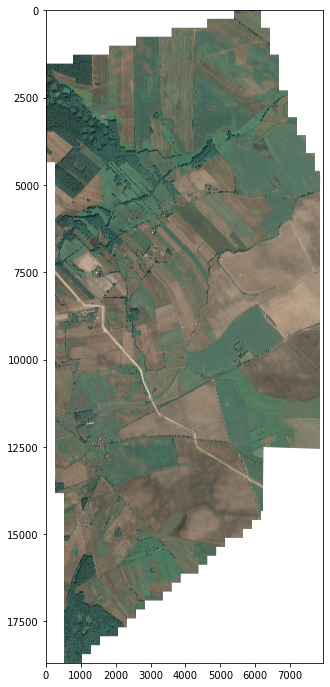

In [16]:
from rasterio.plot import show
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12))

show(mosaic, ax=ax)
plt.show()

# TODO:
- Currently clipping the aoi and the overlap leaves a single "polyline" which is filled with wmts tiles. Unnecessary.
- Handle multiple overlaps. Possibly best to not get multiple overlap sections, but change method to get the best coverage of each scene. No overlap sections.